<a href="https://colab.research.google.com/github/felixsimard/comp551-p3/blob/main/HassanNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Init()



In [110]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader, Dataset

from skimage import io
from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle

from google.colab import drive
from datetime import datetime
from PIL import Image
from sklearn import preprocessing
from tqdm import tqdm

import math
import string
import cv2

In [25]:
# Device configuration
drive.mount("/content/drive")
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
cuda:0


## Hyperparameters

In [26]:
# Hyper-parameters
epochs = 10
batch_size = 64
channels = 1
classes = 36
alpha = 0.001
beta = 0.9
gamma = 0.0001
train_valid_split = 0.3

FLATTEN_IMG_SIZE = 3136
PRODUCTION = False
LABELLING = False

## Pickle Data to Numpy NDArray

In [27]:
def load_data(filename, data_path="/content/drive/MyDrive/data/"):
    loaded_pkl = None
    try:
        pkl_buffered = open(data_path+''+filename,'rb')
        loaded_pkl = pickle.load(pkl_buffered)
    except Exception as e:
        print("Error loading data: {}".format(e))
    return loaded_pkl

In [28]:
# loading all data
train_features = load_data("images_l.pkl")[:, None]
train_labels = load_data("labels_l.pkl")
test = load_data("images_test.pkl")[:, None]
train_unlabelled = load_data("images_ul.pkl")[:, None]

In [29]:
print(train_features.shape, train_features[:1])
print(train_labels.shape, train_labels[:1])

(30000, 1, 56, 56) [[[[  0.   0.   0. ... 175.   0.   0.]
   [  0.   0.   0. ...   0.   0.   0.]
   [  0.   0.   0. ...   0. 175.   0.]
   ...
   [  0.   0.   0. ...   0.   0.   0.]
   [  0.   0.   0. ...   0.   0.   0.]
   [  0.   0.   0. ...   0.   0.   0.]]]]
(30000, 36) [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [30]:
for data in [train_features, train_labels, train_unlabelled, test]:  
  print(type(data) is np.ndarray)

True
True
True
True


## Training & Validation Split

In [31]:
split_index = math.floor(len(train_labels)*train_valid_split)

full_train_l = train_features
val_l = train_features[:split_index]
train_l = train_features[split_index:]

full_train_labels_l = train_labels
val_labels_l = train_labels[:split_index]
train_labels_l = train_labels[split_index:]

print(full_train_l.shape, full_train_labels_l.shape)
print(train_l.shape, train_labels_l.shape)
print(val_l.shape, val_labels_l.shape)

(30000, 1, 56, 56) (30000, 36)
(21000, 1, 56, 56) (21000, 36)
(9000, 1, 56, 56) (9000, 36)


## Tensor DataLoader & Feature Labels (Preprocessing Part I)

In [32]:
# Data transformation parameters
mean = (0.5,)
std = (0.5,)
Transform = transforms.Compose([transforms.Normalize(mean=mean, std=std)])

In [33]:
# Reference: https://stackoverflow.com/questions/44429199/how-to-load-a-list-of-numpy-arrays-to-pytorch-dataset-loader
class MyDataset(Dataset):
    def __init__(self, data, targets=None, transform=None, transform_target=None):
        self.data = torch.from_numpy(data).float()
        self.targets = torch.from_numpy(targets).float() if targets is not None else None
        self.transform = transform
        self.transform_target = transform_target
        
    def __getitem__(self, index):
        x = self.data[index]
        y = np.zeros(36, dtype=float)# self.targets[index]

        if self.targets is not None:
            y = self.targets[index]
        else:
            None
        if self.transform:
            x = self.transform(x)
        if self.transform_target:
            y = self.transform_target(y)
        
        return x, y
    
    
    def __len__(self):
        return len(self.data)

In [34]:
# DataLoaders
all_training = DataLoader(MyDataset(full_train_l, full_train_labels_l, 
                                                   transform=Transform), shuffle=True, batch_size=batch_size)
training = DataLoader(MyDataset(train_l, train_labels_l, 
                                                   transform=Transform), shuffle=True, batch_size=batch_size)
validation = DataLoader(MyDataset(val_l, val_labels_l, 
                                                   transform=Transform), shuffle=True)

# TODO: add unlabelled training data

# Test set for Kaggle
test_labels_ul = np.zeros(len(test))
testing = DataLoader(MyDataset(test, test_labels_ul, 
                                                    transform=Transform), batch_size=batch_size, shuffle=False)

print(len(all_training)*batch_size,len(training)*batch_size, len(testing)*batch_size)

30016 21056 15040


## Image Filtering (Preprocessing Part II)

* Goal of this preprocessing step is to clean input images such that number and letter features are clearer by: 
  - Removing grainy features
  - Sharpening egdes of letters & numbers
  - Creating greater contrast between background and objects

In [35]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


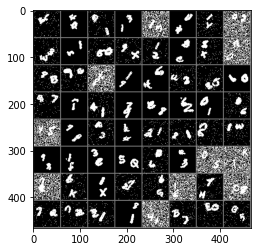

In [40]:
imgs, labels = next(iter(training))
imshow(torchvision.utils.make_grid(imgs.cpu()))


In [44]:
alpha_dict = dict(enumerate(string.ascii_lowercase))
def get_label_value(labels):
  """
  This function will return a string representing the label of a picture given
  the array label as input:
  Ex ouput: '1a', '4z' ...
  """
  label_temp = labels.tolist()
  label_temp = [int(x) for x in label_temp]
  number = label_temp[:10].index(1)
  letter = alpha_dict[label_temp[10:].index(1)]

  return str(number) + str(letter)

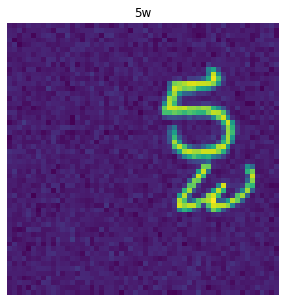

In [50]:
figure = plt.figure(figsize=(5,5))
sample_idx = torch.randint(len(training), size=(1,)).item()
img = train_l[sample_idx]
label = get_label_value(train_labels_l[sample_idx])
plt.title(label)
plt.axis("off")
plt.imshow(img.squeeze())

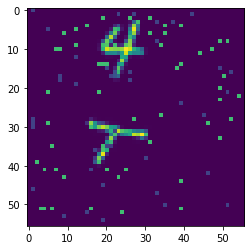

In [104]:
timg = train_l[7]
plt.imshow(timg.squeeze())

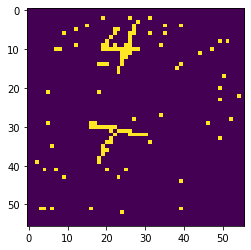

In [141]:
# Shows us the highlighted regions in binary
# if it is yellow, then pixel is closer to 255 (activation)
# if it is black, then pixel is closer to 0 
bin_image = timg[:, :,:] > 125
plt.imshow(bin_image.squeeze())

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/numpy_array_iterator.py:136: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 1, 56, 56) (56 channels).
  str(self.x.shape[channels_axis]) + ' channels).')


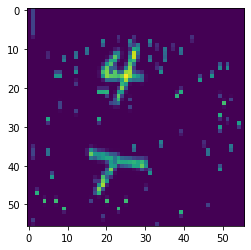

In [167]:
# This is a proof of concept of the Keras data generator
# Run this multiple times to see how the image data is changed

datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

x = img_to_array(timg)
x = x.reshape((1,)+x.shape)

i = 0
for batch in datagen.flow(x, batch_size=12):
  i+=1
  plt.imshow(batch.squeeze())
  if i > 20: break

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/numpy_array_iterator.py:136: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 56, 56) (56 channels).
  str(self.x.shape[channels_axis]) + ' channels).')


TypeError: ignored

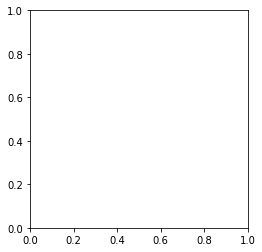

In [169]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

i, l = next(iter(training))
i = img_to_array(i.squeeze())
i = i.reshape((1,)+i.shape)
#train_datagen.fit(i.cpu())

train_generator = train_datagen.flow(
    i,
    batch_size=batch_size
)

for b in train_generator:
  plt.imshow(b.squeeze())
  break


## CNN (AlexNet)

In [58]:
class CNN(nn.Module):
    def __init__(self, in_channels=channels, num_classes=classes):
        super().__init__() # invoke the parent constructor
        self.in_channels = in_channels
        self.num_classes = num_classes
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(self.in_channels, 32, kernel_size=5, padding=2), # (b_sz, 1, 56, 56) --> (b_sz, 16, 56, 56)
            nn.MaxPool2d(2), # (b_sz, 32, 56, 56) --> (b_sz, 32, 28, 28)
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1), # (b_sz, 32, 28, 28) --> (b_sz, 64, 28, 28)
            nn.MaxPool2d(2), # (b_sz, 64, 28, 28) --> (b_sz, 64, 14, 14)
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1), # (b_sz, 64, 14, 14) --> (b_sz, 128, 14, 14)
            #nn.MaxPool2d(2), # (b_sz, 128, 14, 14) --> (b_sz, 128, 7, 7)
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.conv_block4 = nn.Sequential(
            nn.Conv2d(128, 84, kernel_size=3, padding=1), # (b_sz, 128, 14, 14) --> (b_sz, 84, 14, 14)
            nn.BatchNorm2d(84),
            nn.ReLU(),
            nn.Conv2d(84, 84, kernel_size=3, padding=1), # (b_sz, 84, 14, 14) --> (b_sz, 84, 14, 14),
            nn.BatchNorm2d(84),
            nn.ReLU()
        )
        self.maxpool = nn.AdaptiveMaxPool2d(output_size=(6, 6))
        self.dense_block = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(84*6*6, 1512),
            nn.BatchNorm1d(1512),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(1512, 1512),
            nn.BatchNorm1d(1512),
            nn.ReLU(),
            nn.Linear(1512, self.num_classes)
        )
    
    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.conv_block4(x)
        x = self.maxpool(x)
        x = x.view(x.size()[0], -1)
        x = self.dense_block(x)
        return x

## Training & Evaluation Method

In [69]:
# Train function
def train(model, dataloader=training, init_rounds=2):

    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=alpha)

    for epoch in range(epochs):
        running_loss = 0.0
        model.train()

        for i, data in enumerate(dataloader):
            # get data/targets
            inputs, true_targets = data
            inputs = inputs.to(device)
            true_targets = true_targets.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward, backward,
            outputs = model(inputs)
            loss = criterion(outputs, true_targets)

            # backward
            loss.backward()

            # gradient descent step
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            # track learning
            running_loss += loss.item()
            #acc, acc_d, acc_l = eval_model(model, dataloader)
            if i % 100 == 99:    # print every 2000 mini-batches
                # print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 100))
                print('[epoch %d] loss: %.3f'%(epoch+1, running_loss/i))
                running_loss = 0.0
    
    # DONE TRAINING
    print('Finished Training')
    PATH = './cnn.pth'
    torch.save(model.state_dict(), PATH)

In [67]:
# Evaluation function
def eval_model(model, dl):
    accs, accs_d, accs_l = [], [], []
    with torch.no_grad():
        model.eval()
        for i, data in enumerate(dl):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            preds = convert_outputs_to_preds(outputs.cpu().detach().numpy())
            preds_d = preds[:, :11]
            preds_l = preds[:, 11:]
            labels_d = labels[:, :11]
            labels_l = labels[:, 11:]
            accs.append(get_accuracy(preds, labels.cpu()))
            accs_d.append(get_accuracy(preds_d, labels_d.cpu()))
            accs_l.append(get_accuracy(preds_l, labels_l.cpu()))
    return sum(accs)/len(accs), sum(accs_d)/len(accs_d), sum(accs_l)/len(accs_l)

## Testing

In [56]:
def transform_output(scores):
    """
    Input a Tensor and output will be another Tensor with same dimension but with all elements 0 except two.
    Those 2 elements will have value of 1 and will correspond to the models prediction about which letter and number
    is in the image.
    :param scores:
    :return:
    """
    return_array = []
    score_list = scores.tolist()

    for score in score_list:
        numbers = score[:10]
        letters = score[10:]
        test = lambda x, max_value : 1 if x >= max_value else 0

        new_numbers = [test(x, max(numbers)) for x in numbers]
        new_letters = [test(x, max(letters)) for x in letters]

        return_array.append(new_numbers + new_letters)

    return return_array

In [57]:
# Methods to calculate some accuracy metrics
def convert_outputs_to_preds(outputs):
    preds = np.empty(shape=(len(outputs), 36))
    for i, output in enumerate(outputs):
        pred = np.zeros(36)
        digit_index = np.argmax(output[:11])
        letter_index = np.argmax(output[11:]) + 11
        pred[digit_index], pred[letter_index] = 1, 1
        preds[i] = pred
    return preds
    
def correct_digits(preds, labels):
    return np.map((preds, labek))

def correct_letters(preds, labels):
    return np.array_equal(pred[11:],label[11:])

def get_accuracy(preds, labels):
    preds_str = convert_labels_to_strings(preds)
    labels_str = convert_labels_to_strings(labels)
    correct_preds = np.equal(preds_str, labels_str)
    return correct_preds.sum() / len(labels)

def check_prediction(preds, labels):
    return np.equal(preds, labels)

def print_model_weights(model):
    for name, param in model.named_parameters():
      print(name, param.size())    

def convert_labels_to_strings(labels):
  result = np.empty(len(labels)).astype('object')
  for i, pred in enumerate(labels):
    prediction = ''
    for elem in pred:
      prediction = prediction + str(int(elem))
    result[i] = prediction
  return result

## Main()

In [71]:
cnn = CNN().to(device)
train(cnn)
eval_model(cnn, validation)

[epoch 1] loss: 0.450
[epoch 1] loss: 0.184
[epoch 1] loss: 0.104
[epoch 2] loss: 0.259
[epoch 2] loss: 0.112
[epoch 2] loss: 0.065
[epoch 3] loss: 0.162
[epoch 3] loss: 0.072
[epoch 3] loss: 0.044
[epoch 4] loss: 0.108
[epoch 4] loss: 0.051
[epoch 4] loss: 0.032
[epoch 5] loss: 0.079
[epoch 5] loss: 0.038
[epoch 5] loss: 0.026
[epoch 6] loss: 0.064
[epoch 6] loss: 0.030
[epoch 6] loss: 0.021
[epoch 7] loss: 0.050
[epoch 7] loss: 0.026
[epoch 7] loss: 0.018
[epoch 8] loss: 0.043
[epoch 8] loss: 0.022
[epoch 8] loss: 0.015
[epoch 9] loss: 0.040
[epoch 9] loss: 0.019
[epoch 9] loss: 0.012
[epoch 10] loss: 0.037
[epoch 10] loss: 0.017
[epoch 10] loss: 0.012
Finished Training


(0.848, 0.9024444444444445, 0.875)